# Fit a classical ML model to cycle-accurate simulations of intersection units

This notebook is meant to be run on Google Colab. The original link can be found here

https://colab.research.google.com/drive/13ghHiPsVAPKTobchAQa8i5SBTvQefenu?usp=sharing

In [ ]:
import random, importlib, re, math, queue, numpy as np, copy, itertools, pandas as pd, sympy, os, pickle
sp = sympy
from threading import Thread
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sympy import sympify, symbols, prod, Sum, IndexedBase, Idx, Min
import matplotlib.pyplot as plt
import datetime
from google.colab import files
import seaborn as sns

# Clone/pull saftools
cmd=None
if os.path.exists('saftool'):
    print("Pulling latest")
    cmd = 'cd saftool; git pull'
else:
    print("Cloning")
    cmd = 'git clone https://github.com/abf149/saftool.git'
!{cmd}

# Import saftool intersection unit cycle accurate simulators
import saftool.src.cycle_sims.components.isectbd.units.direct_map as direct_mapped_
import saftool.src.cycle_sims.components.isectbd.units.ideal as ideal_
import saftool.src.cycle_sims.components.isectbd.units.skip_ahead as skip_ahead_
import saftool.src.cycle_sims.components.isectbd.units.two_finger as two_finger_

# Import saftool intersection cycle accurate model dataloader and data tools
import saftool.src.cycle_sims.components.isectbd.data.test_case_dataset as d_
import saftool.src.cycle_sims.data.data as d_tools_

# Import poly model, train, test
import saftool.src.cycle_sims.ml.model as mo_
import saftool.src.cycle_sims.ml.test as te_
import saftool.src.cycle_sims.ml.train as tr_

# Import visuzliations
import saftool.src.cycle_sims.viz.plot2d as p2d_

# Individual intersection units
ideal_intersection_unit=ideal_.ideal_intersection_unit
direct_mapped_intersection_unit=direct_mapped_.direct_mapped_intersection_unit
skipahead_radix2_merge_intersection=skip_ahead_.skipahead_radix2_merge_intersection
naive_radix2_merge_intersection=two_finger_.naive_radix2_merge_intersection

# Sympy pretty-printing
sp.init_printing()

In [ ]:
# Target intersection units
isect_unit_list = list([direct_mapped_intersection_unit, \
                            skipahead_radix2_merge_intersection, \
                            naive_radix2_merge_intersection])
isect_unit_dict = {isect.__name__:isect for isect in isect_unit_list}

# Test vectors
v1_unequal = [1,3,5,7,9]
v2_unequal = [5,6,7,9,10]

v1_unequal_singleton_uneq = [5]
v2_unequal_singleton_uneq = [1]

v1_unequal_singleton_eq = [5]
v2_unequal_singleton_eq = [5]

print("Test length-4 vector intersection")
for idx,isect in enumerate(isect_unit_list):
    print("Testing",isect.__name__)
    intersection_unequal, cycle_count_unequal, v1_empty_unequal, v2_empty_unequal = isect(copy.copy(v1_unequal), copy.copy(v2_unequal))
    print(intersection_unequal, cycle_count_unequal, v1_empty_unequal, v2_empty_unequal)

print("Test length-1 vector intersection (unequal)")
#
# Unequal singleton
for idx,isect in enumerate(isect_unit_list):
    print("Testing",isect.__name__)
    intersection_unequal, cycle_count_unequal, v1_empty_unequal, v2_empty_unequal = isect(copy.copy(v1_unequal_singleton_uneq), copy.copy(v2_unequal_singleton_uneq))
    print(intersection_unequal, cycle_count_unequal, v1_empty_unequal, v2_empty_unequal)

print("Test length-1 vector intersection (equal)")
# Equal singleton
for idx,isect in enumerate(isect_unit_list):
    print("Testing",isect.__name__)
    intersection_unequal, cycle_count_unequal, v1_empty_unequal, v2_empty_unequal = isect(copy.copy(v1_unequal_singleton_eq), copy.copy(v2_unequal_singleton_eq))
    print(intersection_unequal, cycle_count_unequal, v1_empty_unequal, v2_empty_unequal)

Test length-4 vector intersection
Testing direct_mapped_intersection_unit
[5, 7, 9] 1 True False
Testing skipahead_radix2_merge_intersection
[5, 7, 9] 3 True False
Testing naive_radix2_merge_intersection
[5, 7, 9] 6 True False
Test length-1 vector intersection (unequal)
Testing direct_mapped_intersection_unit
[] 1 False True
Testing skipahead_radix2_merge_intersection
[] 1 False True
Testing naive_radix2_merge_intersection
[] 1 False True
Test length-1 vector intersection (equal)
Testing direct_mapped_intersection_unit
[5] 1 True True
Testing skipahead_radix2_merge_intersection
[5] 1 True True
Testing naive_radix2_merge_intersection
[5] 1 True True


In [ ]:
print(isect_unit_list)

[<function direct_mapped_intersection_unit at 0x7b5f6b2b63b0>, <function skipahead_radix2_merge_intersection at 0x7b5f6b2b6710>, <function naive_radix2_merge_intersection at 0x7b5f6b2b6830>]


## Dataloader params

In [ ]:
# Usage
#sparsity0_range = (0.1, 1.0)
#sparsity1_range = (0.1, 1.0)
#fiber_length_values = [256]
#vector_length_values = [32]
#batch_size = 1000
#num_tests = 1000

## Metric computation

In [ ]:
def calculate_conditional_max_error(test_cases, true_targets, predicted_results, eval_sparsity0_range, eval_sparsity1_range):
    # Calculate sparsities
    sparsity0 = test_cases[:, 0] / test_cases[:, 2]
    sparsity1 = test_cases[:, 1] / test_cases[:, 2]

    # Create mask based on sparsity conditions
    mask = (sparsity0 >= eval_sparsity0_range[0]) & (sparsity0 <= eval_sparsity0_range[1]) & \
           (sparsity1 >= eval_sparsity1_range[0]) & (sparsity1 <= eval_sparsity1_range[1])

    # Apply mask
    filtered_true_targets = true_targets[mask]
    filtered_predicted_results = predicted_results[mask]

    # Calculate conditional max error
    #print(filtered_true_targets)
    #print(filtered_predicted_results)
    conditional_max_error = np.max(np.abs(filtered_predicted_results - filtered_true_targets))

    return conditional_max_error

def calculate_conditional_max_error_pct(test_cases, true_targets, predicted_results, eval_sparsity0_range, eval_sparsity1_range):
    # Calculate sparsities
    sparsity0 = test_cases[:, 0] / test_cases[:, 2]
    sparsity1 = test_cases[:, 1] / test_cases[:, 2]

    # Create mask based on sparsity conditions
    mask = (sparsity0 >= eval_sparsity0_range[0]) & (sparsity0 <= eval_sparsity0_range[1]) & \
           (sparsity1 >= eval_sparsity1_range[0]) & (sparsity1 <= eval_sparsity1_range[1])

    # Apply mask
    filtered_true_targets = true_targets[mask]
    filtered_predicted_results = predicted_results[mask]

    # Calculate conditional max error percentage
    conditional_max_error_pct = np.max(np.abs((filtered_predicted_results - filtered_true_targets) / filtered_true_targets))

    return conditional_max_error_pct

## Train loop

In [ ]:
# 'average_result_length'
def run_case(dataloader, target_features, degree, column_expression, cfg={}):
    print("-- target_features:",target_features,"degree:",degree,"column_expression:",column_expression, "cfg=",cfg)

    model, predicted_results, mse_r2, test_cases, true_targets = tr_.train_model_expression(dataloader, \
                                                                                            column_expression, \
                                                                                            target_features, \
                                                                                            degree=degree)
    max_error = np.max(np.abs(predicted_results-true_targets))
    max_error_pct = np.max(np.abs((predicted_results-true_targets)/true_targets))
    conditional_max_error = calculate_conditional_max_error(test_cases, true_targets, predicted_results, cfg['eval_sparsity0_range'], cfg['eval_sparsity1_range'])
    conditional_max_error_pct = calculate_conditional_max_error_pct(test_cases, true_targets, predicted_results, cfg['eval_sparsity0_range'], cfg['eval_sparsity1_range'])
    var_error = np.var(np.abs(predicted_results-true_targets))
    var_error_pct = np.var(np.abs((predicted_results-true_targets)/true_targets))

    train_res = {
      'model':model, \
      'predicted_results':predicted_results, \
      'mse_r2':mse_r2, \
      'test_cases':test_cases, \
      'true_targets':true_targets, \
      'max_error':max_error, \
      'max_error_pct':max_error_pct, \
      'conditional_max_error':conditional_max_error, \
      'conditional_max_error_pct':conditional_max_error_pct, \
      'var_error':var_error, \
      'var_error_pct':var_error_pct, \
    }

    print("--- Train max error %:",100.0*max_error_pct,"%")
    print("--- Train conditional max error % [",cfg['eval_sparsity0_range'],"] [",cfg['eval_sparsity1_range'],"]:",100.0*conditional_max_error_pct,"%")

    model, mse_r2, predicted_results, test_cases, true_targets = te_.test_model_expression(model, \
                                                                                           dataloader, \
                                                                                           column_expression, \
                                                                                           target_features)

    max_error = np.max(np.abs(predicted_results-true_targets))
    max_error_pct = np.max(np.abs((predicted_results-true_targets)/true_targets))
    conditional_max_error = calculate_conditional_max_error(test_cases, true_targets, predicted_results, cfg['eval_sparsity0_range'], cfg['eval_sparsity1_range'])
    conditional_max_error_pct = calculate_conditional_max_error_pct(test_cases, true_targets, predicted_results, cfg['eval_sparsity0_range'], cfg['eval_sparsity1_range'])
    var_error = np.var(np.abs(predicted_results-true_targets))
    var_error_pct = np.var(np.abs((predicted_results-true_targets)/true_targets))

    test_res = {
      'model':model, \
      'predicted_results':predicted_results, \
      'mse_r2':mse_r2, \
      'test_cases':test_cases, \
      'true_targets':true_targets, \
      'max_error':max_error, \
      'max_error_pct':max_error_pct, \
      'conditional_max_error':conditional_max_error, \
      'conditional_max_error_pct':conditional_max_error_pct, \
      'var_error':var_error, \
      'var_error_pct':var_error_pct, \
    }

    print("--- Test max error %:",100.0*max_error_pct,"%")
    print("--- Test conditional max error % [",cfg['eval_sparsity0_range'],"] [",cfg['eval_sparsity1_range'],"]:",100.0*conditional_max_error_pct,"%")

    res = {'degree':degree,
           'target_features':target_features, \
           'column_expression':column_expression, \
           'train_res':train_res, \
           'test_res':test_res, \
           'cfg':copy.deepcopy(cfg)}

    print("--- => Done")

    return res

In [ ]:
def grid_search_best_degree(dataloader, target_features, column_expression, max_degree=3, objective='max_error_pct', obj_tolerance=0.01, cfg={}):
    best_degree = None
    best_result = None
    best_objective_value = float('inf')

    print("- Grid search over degree in [1 ,",max_degree,"] for target_features:",target_features,"column_expression:",column_expression, "cfg=",cfg)
    for degree in range(1, max_degree + 1):
        res = run_case(dataloader, target_features, degree, column_expression, cfg)
        current_objective_value = res['test_res'][objective]

        # Check if the current objective is better and update the best results
        if current_objective_value < best_objective_value:
            best_degree = degree
            best_result = res
            best_objective_value = current_objective_value

            # Check if the objective value is less than tolerance
            if best_objective_value < obj_tolerance:
                print(f"Objective tolerance met at degree {degree} with {objective} = {best_objective_value}")
                break
        else:
            print(f"Performance worsened at degree {degree}. Best was degree {best_degree} with {objective} = {best_objective_value}")
            break

    print("- => Done, grid search over degree")

    return best_degree, best_result

# Example usage
# dataloader, target_features, and column_expression should be defined in your context
# best_degree, best_result = grid_search_best_degree(dataloader, target_features, column_expression)


In [ ]:
def wrapper_over_grid_search(meta_test_cases, \
                             target_features, \
                             column_expression, \
                             sparsity0_range, \
                             sparsity1_range, \
                             batch_size, \
                             num_tests, \
                             isect_fxn, \
                             max_degree=3, \
                             objective='conditional_max_error_pct', \
                             obj_tolerance=0.01, \
                             cfg={}):
    results = []

    for meta_case in meta_test_cases:
        fiber_length_value = meta_case['fiberLength']
        vector_length_value = meta_case['vectorLength']

        #print(sparsity0_range)
        #print(sparsity1_range)
        print("Testing fiberLength =",fiber_length_value,"vector_length_value =",vector_length_value)
        #print(batch_size)
        #print(num_tests)

        # Create dataloader
        dataloader = d_.test_case_dataloader_from_params(sparsity0_range,
                                                         sparsity1_range,
                                                         [fiber_length_value],
                                                         [vector_length_value],
                                                         batch_size,
                                                         num_tests,
                                                         isect_fxn)

        # Perform grid search for the best degree
        best_degree, best_result = grid_search_best_degree(dataloader,
                                                           target_features,
                                                           column_expression,
                                                           max_degree,
                                                           objective,
                                                           obj_tolerance,
                                                           cfg)

        # Construct and append the result dict
        results.append({
            'best_degree': best_degree,
            'best_result': best_result
        })

    return results

In [ ]:
def wrapper_for_intersection_units(isect_unit_list, meta_test_cases, target_features, column_expression, sparsity0_range, sparsity1_range, batch_size, num_tests, max_degree=3, objective='conditional_max_error_pct', obj_tolerance=0.01, cfg={}):
    all_results = {}

    for isect_unit in isect_unit_list:
        isect_unit_name = isect_unit.__name__
        print(f"Testing with intersection unit: {isect_unit_name}")

        results = wrapper_over_grid_search(meta_test_cases, target_features, column_expression, sparsity0_range, sparsity1_range, batch_size, num_tests, isect_unit, max_degree, objective, obj_tolerance, cfg)
        all_results[isect_unit_name] = results

    return all_results

In [ ]:
def generate_meta_test_cases(fiberLength_list, vectorLength_list):
    meta_test_cases = []
    for fiberLength in fiberLength_list:
        for vectorLength in vectorLength_list:
            meta_test_case = {
                "fiberLength": fiberLength,
                "vectorLength": vectorLength
            }
            meta_test_cases.append(meta_test_case)
    return meta_test_cases

In [ ]:
d_.input_features

['compressedFiberLength0',
 'compressedFiberLength1',
 'fiberLength',
 'vectorLength']

In [ ]:
target_features = d_.target_features
column_expression = 'average_result_length/average_cycles_per_intersection'
fiberLength_list = [8,16,32]
vectorLength_list = [1,2,4]
sparsity0_range = (0.1, 1.0)
sparsity1_range = (0.1, 1.0)
batch_size = 100
num_tests = 1000
tol = 0.55
max_degree = 3
obj = 'conditional_max_error_pct'
cfg={"eval_sparsity0_range":[0.3,0.7],"eval_sparsity1_range":[0.3,0.7]}

meta_test_cases=generate_meta_test_cases(fiberLength_list, vectorLength_list)

print(meta_test_cases)

[{'fiberLength': 8, 'vectorLength': 1}, {'fiberLength': 8, 'vectorLength': 2}, {'fiberLength': 8, 'vectorLength': 4}, {'fiberLength': 16, 'vectorLength': 1}, {'fiberLength': 16, 'vectorLength': 2}, {'fiberLength': 16, 'vectorLength': 4}, {'fiberLength': 32, 'vectorLength': 1}, {'fiberLength': 32, 'vectorLength': 2}, {'fiberLength': 32, 'vectorLength': 4}]


In [ ]:
all_results = wrapper_for_intersection_units(isect_unit_list, \
                                             meta_test_cases, \
                                             target_features, \
                                             column_expression, \
                                             sparsity0_range, \
                                             sparsity1_range, \
                                             batch_size, \
                                             num_tests, \
                                             max_degree=max_degree, \
                                             objective=obj, \
                                             obj_tolerance=tol, \
                                             cfg=cfg)

Testing with intersection unit: direct_mapped_intersection_unit
Testing fiberLength = 8 vector_length_value = 1
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}


Running test cases: 100%|██████████| 100/100 [00:06<00:00, 15.44it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0012103462879283356
R^2 Score: 0.966986823085418
--- Train max error %: 21.90823185909346 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 6.144351120680146 %


Running test cases: 100%|██████████| 100/100 [00:07<00:00, 13.73it/s]


Mean Squared Error (MSE): 0.000948491197302309
R^2 Score: 0.9719475301244825
--- Test max error %: 30.214450117021908 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 6.912269591890809 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.06912269591890809
- => Done, grid search over degree
Testing fiberLength = 8 vector_length_value = 2
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_in

Running test cases: 100%|██████████| 100/100 [00:03<00:00, 28.81it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0028056747919657566
R^2 Score: 0.9547495326947361
--- Train max error %: 34.08132729392519 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 12.587526415872977 %


Running test cases: 100%|██████████| 100/100 [00:03<00:00, 31.30it/s]


Mean Squared Error (MSE): 0.0029009925345523458
R^2 Score: 0.9516146186118347
--- Test max error %: 52.8830398692164 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 13.497944809403355 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.13497944809403356
- => Done, grid search over degree
Testing fiberLength = 8 vector_length_value = 4
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_in

Running test cases: 100%|██████████| 100/100 [00:02<00:00, 34.44it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.06564159092708212
R^2 Score: 0.8028439894493321
--- Train max error %: 46.42059395928398 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 39.93031954211064 %


Running test cases: 100%|██████████| 100/100 [00:03<00:00, 25.94it/s]


Mean Squared Error (MSE): 0.05328609465976185
R^2 Score: 0.8327336211068191
--- Test max error %: 48.86094219198166 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 40.90778800559793 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.4090778800559793
- => Done, grid search over degree
Testing fiberLength = 16 vector_length_value = 1
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_inte

Running test cases: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0010895775688781614
R^2 Score: 0.962786056569946
--- Train max error %: 39.30116245898574 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 8.913527282091012 %


Running test cases: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


Mean Squared Error (MSE): 0.001896161705716785
R^2 Score: 0.9440592568680546
--- Test max error %: 44.910381867824015 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 7.972219595744099 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.079722195957441
- => Done, grid search over degree
Testing fiberLength = 16 vector_length_value = 2
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_int

Running test cases: 100%|██████████| 100/100 [00:05<00:00, 19.77it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0015625970148488693
R^2 Score: 0.9780440731686808
--- Train max error %: 33.15748735667352 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 8.53628750635322 %


Running test cases: 100%|██████████| 100/100 [00:06<00:00, 15.66it/s]


Mean Squared Error (MSE): 0.001768293949206009
R^2 Score: 0.9766539749499789
--- Test max error %: 29.079402712403198 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 9.912061017905385 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.09912061017905385
- => Done, grid search over degree
Testing fiberLength = 16 vector_length_value = 4
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_i

Running test cases: 100%|██████████| 100/100 [00:04<00:00, 22.30it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.011681900141803458
R^2 Score: 0.9525392364360721
--- Train max error %: 69.28548370639305 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 14.865425829922065 %


Running test cases: 100%|██████████| 100/100 [00:04<00:00, 23.70it/s]


Mean Squared Error (MSE): 0.011194921530848757
R^2 Score: 0.9493676489220993
--- Test max error %: 43.889640533980966 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 14.657999411683138 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.14657999411683137
- => Done, grid search over degree
Testing fiberLength = 32 vector_length_value = 1
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_

Running test cases: 100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.002103450730296551
R^2 Score: 0.9367822095799231
--- Train max error %: 50.56940085632314 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 11.620270508084008 %


Running test cases: 100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Mean Squared Error (MSE): 0.0012827450573276214
R^2 Score: 0.9517172701152732
--- Test max error %: 59.67372741757815 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 10.140408959854048 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.10140408959854047
- => Done, grid search over degree
Testing fiberLength = 32 vector_length_value = 2
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_

Running test cases: 100%|██████████| 100/100 [00:10<00:00,  9.69it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0008155491326135222
R^2 Score: 0.9890593279341188
--- Train max error %: 35.21269795048212 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 12.749953127792995 %


Running test cases: 100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


Mean Squared Error (MSE): 0.0009920011282351841
R^2 Score: 0.9852711350253951
--- Test max error %: 37.26740949158774 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 12.510683688001306 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.12510683688001306
- => Done, grid search over degree
Testing fiberLength = 32 vector_length_value = 4
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_

Running test cases: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0038878711900029255
R^2 Score: 0.9804538437514729
--- Train max error %: 49.09473899590912 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 9.139793197904536 %


Running test cases: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


Mean Squared Error (MSE): 0.004158036626315829
R^2 Score: 0.9771842388553642
--- Test max error %: 52.054576175719724 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 16.099205257135708 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.16099205257135707
- => Done, grid search over degree
Testing with intersection unit: skipahead_radix2_merge_intersection
Testing fiberLength = 8 vector_length_value = 1
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] deg

Running test cases: 100%|██████████| 100/100 [00:04<00:00, 24.14it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0012517857061898126
R^2 Score: 0.963485303337661
--- Train max error %: 19.756592545601865 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 7.605628025863609 %


Running test cases: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Mean Squared Error (MSE): 0.0009993958376682394
R^2 Score: 0.970265706556561
--- Test max error %: 27.648908985201547 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 7.729453499811168 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.07729453499811167
- => Done, grid search over degree
Testing fiberLength = 8 vector_length_value = 2
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_in

Running test cases: 100%|██████████| 100/100 [00:05<00:00, 19.91it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.001110424723283808
R^2 Score: 0.963050735631102
--- Train max error %: 15.864058672680295 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 10.160701286858542 %


Running test cases: 100%|██████████| 100/100 [00:03<00:00, 26.48it/s]


Mean Squared Error (MSE): 0.0014104898381931854
R^2 Score: 0.9540981341913256
--- Test max error %: 17.092654693221263 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 10.934360388061233 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.10934360388061233
- => Done, grid search over degree
Testing fiberLength = 8 vector_length_value = 4
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_

Running test cases: 100%|██████████| 100/100 [00:03<00:00, 30.58it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0011012471360216504
R^2 Score: 0.9571873833448168
--- Train max error %: 52.99847558121904 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 8.043682871995815 %


Running test cases: 100%|██████████| 100/100 [00:03<00:00, 25.88it/s]


Mean Squared Error (MSE): 0.000963927183996454
R^2 Score: 0.9687247769635959
--- Test max error %: 44.41912579293674 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 7.277187295871489 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.07277187295871489
- => Done, grid search over degree
Testing fiberLength = 16 vector_length_value = 1
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_in

Running test cases: 100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0010144455567630483
R^2 Score: 0.9753162374976951
--- Train max error %: 32.57229326649554 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 11.810910252104465 %


Running test cases: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


Mean Squared Error (MSE): 0.0011412797619870547
R^2 Score: 0.9738344394935236
--- Test max error %: 41.79209244948372 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 9.435566338586607 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.09435566338586608
- => Done, grid search over degree
Testing fiberLength = 16 vector_length_value = 2
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_i

Running test cases: 100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0011459437047036721
R^2 Score: 0.9522605702656335
--- Train max error %: 26.360556779168636 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 7.408407854250864 %


Running test cases: 100%|██████████| 100/100 [00:07<00:00, 13.22it/s]


Mean Squared Error (MSE): 0.001325188284760407
R^2 Score: 0.9524524685092925
--- Test max error %: 27.886873357546516 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 9.03447439482399 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.0903447439482399
- => Done, grid search over degree
Testing fiberLength = 16 vector_length_value = 4
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_int

Running test cases: 100%|██████████| 100/100 [00:05<00:00, 19.36it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0006748172707444662
R^2 Score: 0.9741933553037243
--- Train max error %: 56.998926913929495 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 9.68229505288354 %


Running test cases: 100%|██████████| 100/100 [00:06<00:00, 14.33it/s]


Mean Squared Error (MSE): 0.0008224069300216139
R^2 Score: 0.9596120839285271
--- Test max error %: 25.08054257148113 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 13.91978784154799 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.1391978784154799
- => Done, grid search over degree
Testing fiberLength = 32 vector_length_value = 1
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_in

Running test cases: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.001290177682422412
R^2 Score: 0.9547182754072447
--- Train max error %: 44.455416970524745 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 7.198676814288964 %


Running test cases: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Mean Squared Error (MSE): 0.0013376231800498934
R^2 Score: 0.9569561878342869
--- Test max error %: 78.25147924085907 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 9.763515900875483 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.09763515900875483
- => Done, grid search over degree
Testing fiberLength = 32 vector_length_value = 2
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_i

Running test cases: 100%|██████████| 100/100 [00:11<00:00,  8.79it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0014398613421669712
R^2 Score: 0.9553590941331395
--- Train max error %: 48.64642306013673 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 8.42316247796926 %


Running test cases: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


Mean Squared Error (MSE): 0.0010593800808836092
R^2 Score: 0.9628547539903595
--- Test max error %: 44.2359952693204 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 10.215419936948008 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.10215419936948007
- => Done, grid search over degree
Testing fiberLength = 32 vector_length_value = 4
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_i

Running test cases: 100%|██████████| 100/100 [00:10<00:00,  9.38it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0004105937785867392
R^2 Score: 0.9828478318074702
--- Train max error %: 31.399544682036908 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 5.279002641916946 %


Running test cases: 100%|██████████| 100/100 [00:10<00:00,  9.50it/s]


Mean Squared Error (MSE): 0.000685718798600968
R^2 Score: 0.9763431197742435
--- Test max error %: 29.183476073237014 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 5.176553951242022 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.051765539512420224
- => Done, grid search over degree
Testing with intersection unit: naive_radix2_merge_intersection
Testing fiberLength = 8 vector_length_value = 1
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree:

Running test cases: 100%|██████████| 100/100 [00:03<00:00, 30.33it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0014001801954638996
R^2 Score: 0.9410849516549393
--- Train max error %: 27.789211308349294 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 5.20646033573173 %


Running test cases: 100%|██████████| 100/100 [00:03<00:00, 29.32it/s]


Mean Squared Error (MSE): 0.002228060460103752
R^2 Score: 0.9277743540830806
--- Test max error %: 23.278779549220026 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 7.977110723537089 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.07977110723537088
- => Done, grid search over degree
Testing fiberLength = 8 vector_length_value = 2
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_in

Running test cases: 100%|██████████| 100/100 [00:04<00:00, 20.94it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0010887886237183452
R^2 Score: 0.923284461231157
--- Train max error %: 20.370865078645547 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 8.473477386977898 %


Running test cases: 100%|██████████| 100/100 [00:03<00:00, 32.94it/s]


Mean Squared Error (MSE): 0.000662419723642213
R^2 Score: 0.9400482092926638
--- Test max error %: 36.943934633344966 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 6.13271999554751 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.0613271999554751
- => Done, grid search over degree
Testing fiberLength = 8 vector_length_value = 4
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_inte

Running test cases: 100%|██████████| 100/100 [00:02<00:00, 35.57it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.003251362403968938
R^2 Score: 0.8491441042405821
--- Train max error %: 40.51729272724573 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 14.05854034060409 %


Running test cases: 100%|██████████| 100/100 [00:03<00:00, 33.06it/s]


Mean Squared Error (MSE): 0.0007640068575569106
R^2 Score: 0.9364384178127912
--- Test max error %: 15.05189816880373 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 14.26612319795365 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.1426612319795365
- => Done, grid search over degree
Testing fiberLength = 16 vector_length_value = 1
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_in

Running test cases: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0008835707209242733
R^2 Score: 0.9742003342015693
--- Train max error %: 32.235409350231734 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 4.878591434179142 %


Running test cases: 100%|██████████| 100/100 [00:05<00:00, 17.97it/s]


Mean Squared Error (MSE): 0.0010263999288073896
R^2 Score: 0.9664495638766212
--- Test max error %: 46.5640359618367 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 9.827922516274377 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.09827922516274377
- => Done, grid search over degree
Testing fiberLength = 16 vector_length_value = 2
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_in

Running test cases: 100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0005619682010852663
R^2 Score: 0.9597041052976787
--- Train max error %: 34.84206251895802 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 6.918025482566699 %


Running test cases: 100%|██████████| 100/100 [00:04<00:00, 20.68it/s]


Mean Squared Error (MSE): 0.0008968276962153164
R^2 Score: 0.9470334692489273
--- Test max error %: 35.35890321209923 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 6.27293477727552 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.0627293477727552
- => Done, grid search over degree
Testing fiberLength = 16 vector_length_value = 4
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_int

Running test cases: 100%|██████████| 100/100 [00:04<00:00, 20.24it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0005482461049446003
R^2 Score: 0.9486130494645947
--- Train max error %: 28.931661451415792 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 10.729261406296681 %


Running test cases: 100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


Mean Squared Error (MSE): 0.0008128902607305359
R^2 Score: 0.9187872599059764
--- Test max error %: 31.717117263940974 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 10.345459232922753 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.10345459232922753
- => Done, grid search over degree
Testing fiberLength = 32 vector_length_value = 1
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per

Running test cases: 100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.000990713633487053
R^2 Score: 0.9613892835563795
--- Train max error %: 48.91561489753628 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 10.699560181996388 %


Running test cases: 100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Mean Squared Error (MSE): 0.0009502178114400323
R^2 Score: 0.9667687647497024
--- Test max error %: 40.30704315566248 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 10.029609841497434 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.10029609841497435
- => Done, grid search over degree
Testing fiberLength = 32 vector_length_value = 2
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_

Running test cases: 100%|██████████| 100/100 [00:09<00:00, 10.81it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.0005600640846550832
R^2 Score: 0.9598882287989307
--- Train max error %: 61.8781131141804 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 8.934641937528639 %


Running test cases: 100%|██████████| 100/100 [00:10<00:00,  9.46it/s]


Mean Squared Error (MSE): 0.0007214139959475483
R^2 Score: 0.9533892239054058
--- Test max error %: 63.2176366404841 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 7.841544653720558 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.07841544653720559
- => Done, grid search over degree
Testing fiberLength = 32 vector_length_value = 4
- Grid search over degree in [1 , 3 ] for target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] column_expression: average_result_length/average_cycles_per_intersection cfg= {'eval_sparsity0_range': [0.3, 0.7], 'eval_sparsity1_range': [0.3, 0.7]}
-- target_features: ['average_total_cycles', 'average_num_intersections', 'average_cycles_per_intersection', 'average_result_length', 'average_num_full_length_intersections'] degree: 1 column_expression: average_result_length/average_cycles_per_in

Running test cases: 100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


Removed 0 rows containing zeros.
Mean Squared Error (MSE): 0.00033655625754281217
R^2 Score: 0.9726401442209733
--- Train max error %: 39.526927100583556 %
--- Train conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 5.80373882805424 %


Running test cases: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


Mean Squared Error (MSE): 0.0004618799963721521
R^2 Score: 0.9629095657160274
--- Test max error %: 49.57278172312969 %
--- Test conditional max error % [ [0.3, 0.7] ] [ [0.3, 0.7] ]: 7.364036369498446 %
--- => Done
Objective tolerance met at degree 1 with conditional_max_error_pct = 0.07364036369498446
- => Done, grid search over degree


In [ ]:
def pickle_list_with_timestamp_and_download(data_list, filename_prefix):
    """
    Pickles the given list to a file named with the provided prefix and a timestamp, and prompts a download in Google Colab.

    Args:
    data_list (list): The list to be pickled.
    filename_prefix (str): The prefix for the filename.

    Returns:
    str: The name of the file where the list is pickled.
    """
    # Getting the current timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Generating the filename with timestamp
    filename = f'{filename_prefix}_{timestamp}.pkl'

    # Pickling the list with the timestamped filename
    with open(filename, 'wb') as f:
        pickle.dump(data_list, f)

    # Prompting a download
    files.download(filename)

    return filename

In [ ]:
result_fn = pickle_list_with_timestamp_and_download({"all_results":all_results,"meta_test_cases":meta_test_cases},"results_"+str(str(tol)+"_0p3_0p7_"))
print(result_fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

results_0.55_0p3_0p7__20240123-100915.pkl


In [ ]:
def summarize_results(all_results):
    res={}
    for isect_unit_name in all_results:
        results = all_results[isect_unit_name]
        degree_list = [results[idx]['best_degree'] for idx in range(len(results))]
        obj_list = [results[idx]['best_result']['test_res'][obj] for idx in range(len(results))]
        max_error_pct_list = [results[idx]['best_result']['test_res']['max_error_pct'] for idx in range(len(results))]
        res[isect_unit_name]={'degree_list':degree_list,'obj_list':obj_list,'max_error_pct_list':max_error_pct_list}
        print("isect_unit_name:",isect_unit_name)
        print("- degree list:",degree_list)
        print("-",obj,"list:",obj_list)
        print("- max_error_pct_list",max_error_pct_list)
    return res

In [ ]:
all_res_summary = summarize_results(all_results)

isect_unit_name: direct_mapped_intersection_unit
- degree list: [1, 1, 1, 1, 1, 1, 1, 1, 1]
- conditional_max_error_pct list: [0.06912269591890809, 0.13497944809403356, 0.4090778800559793, 0.079722195957441, 0.09912061017905385, 0.14657999411683137, 0.10140408959854047, 0.12510683688001306, 0.16099205257135707]
- max_error_pct_list [0.30214450117021907, 0.528830398692164, 0.4886094219198166, 0.4491038186782402, 0.29079402712403196, 0.43889640533980967, 0.5967372741757815, 0.3726740949158774, 0.5205457617571972]
isect_unit_name: skipahead_radix2_merge_intersection
- degree list: [1, 1, 1, 1, 1, 1, 1, 1, 1]
- conditional_max_error_pct list: [0.07729453499811167, 0.10934360388061233, 0.07277187295871489, 0.09435566338586608, 0.0903447439482399, 0.1391978784154799, 0.09763515900875483, 0.10215419936948007, 0.051765539512420224]
- max_error_pct_list [0.2764890898520155, 0.17092654693221263, 0.4441912579293674, 0.4179209244948372, 0.27886873357546516, 0.2508054257148113, 0.7825147924085907, 

In [ ]:
def plot_result(res_summary, meta_test_cases, isect_unit_name):

    # Extracting results
    degree_list = res_summary['degree_list']
    obj_list = res_summary['obj_list']
    max_error_pct_list = res_summary['max_error_pct_list']

    # Creating X labels from meta test cases
    x_labels = [f'FL{tc["fiberLength"]}_VL{tc["vectorLength"]}' for tc in meta_test_cases]

    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Degree Bar Chart
    axs[0].bar(x_labels, degree_list)
    axs[0].set_title(isect_unit_name+': Degree vs Test Cases')
    axs[0].set_xlabel('Test Cases')
    axs[0].set_ylabel('Degree')

    # Conditional Max Error Percentage Bar Chart
    axs[1].bar(x_labels, obj_list)
    axs[1].set_title(isect_unit_name+': Conditional Max Error Percentage vs Test Cases')
    axs[1].set_xlabel('Test Cases')
    axs[1].set_ylabel('Conditional Max Error Pct')

    # Max Error Percentage Bar Chart
    axs[2].bar(x_labels, max_error_pct_list)
    axs[2].set_title(isect_unit_name+': Max Error Percentage vs Test Cases')
    axs[2].set_xlabel('Test Cases')
    axs[2].set_ylabel('Max Error Pct')

    plt.tight_layout()
    plt.show()

isect unit: direct_mapped_intersection_unit


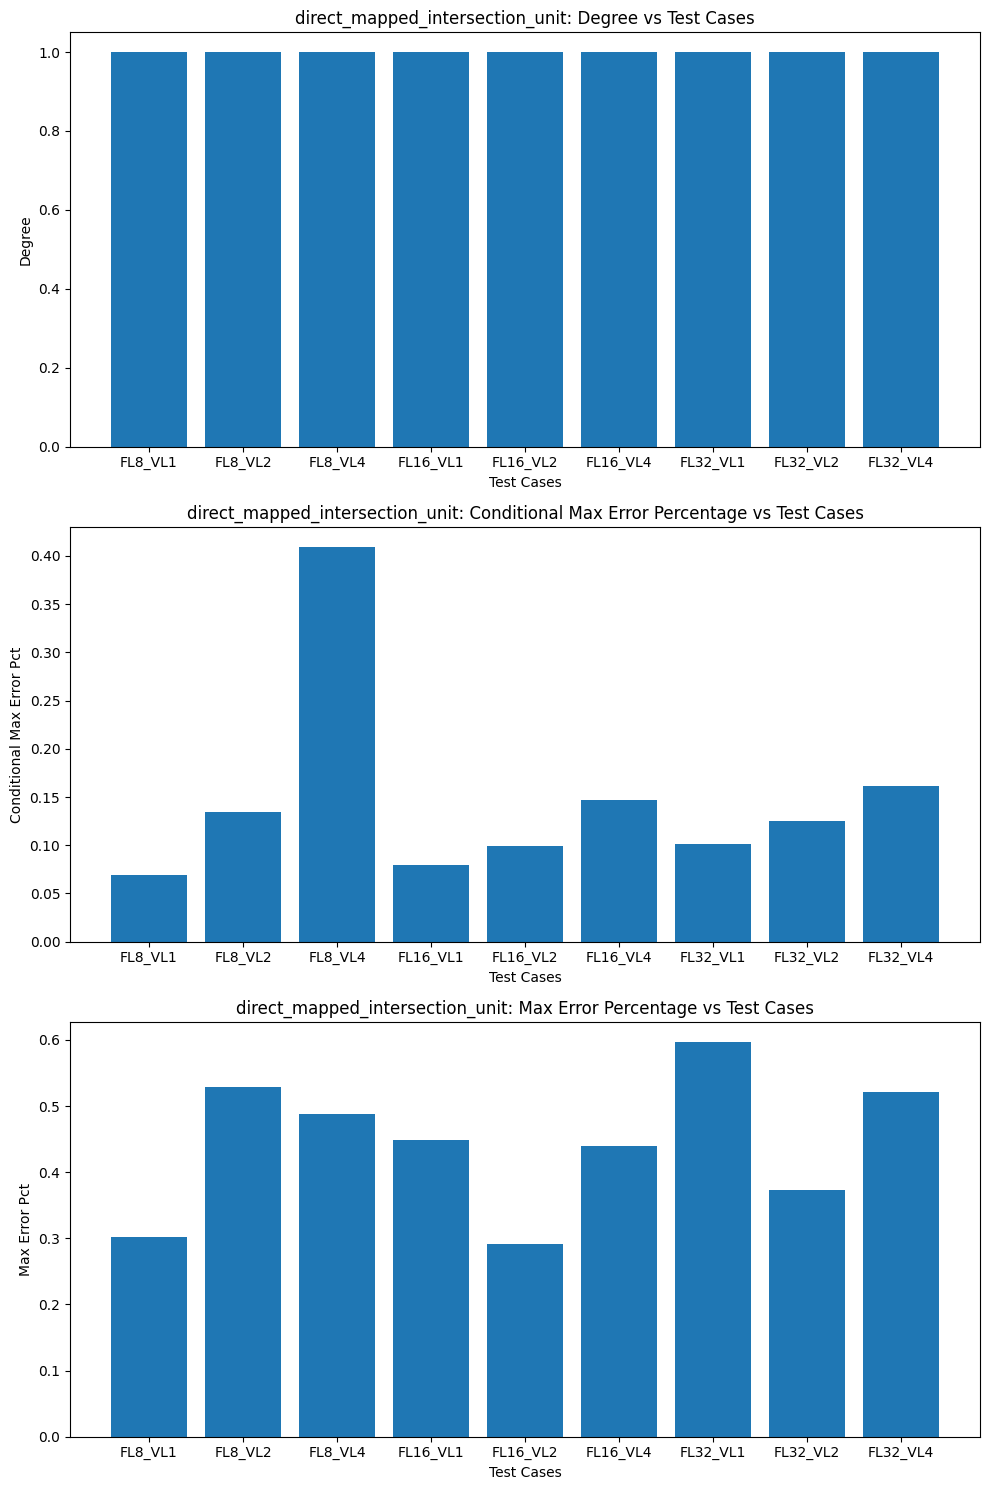

isect unit: skipahead_radix2_merge_intersection


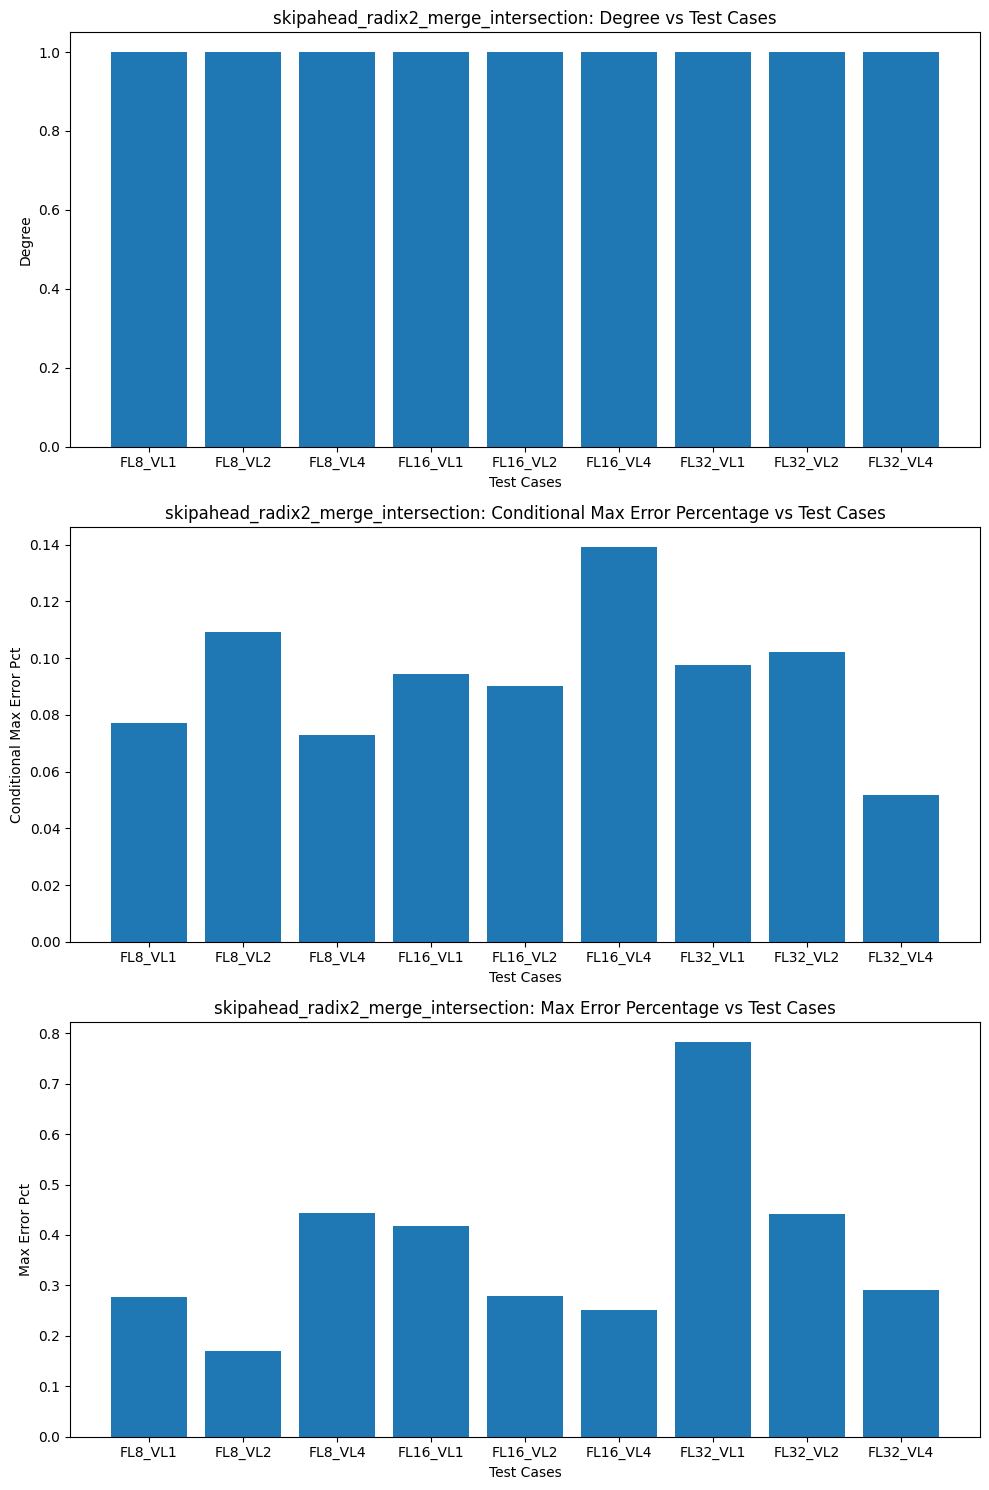

isect unit: naive_radix2_merge_intersection


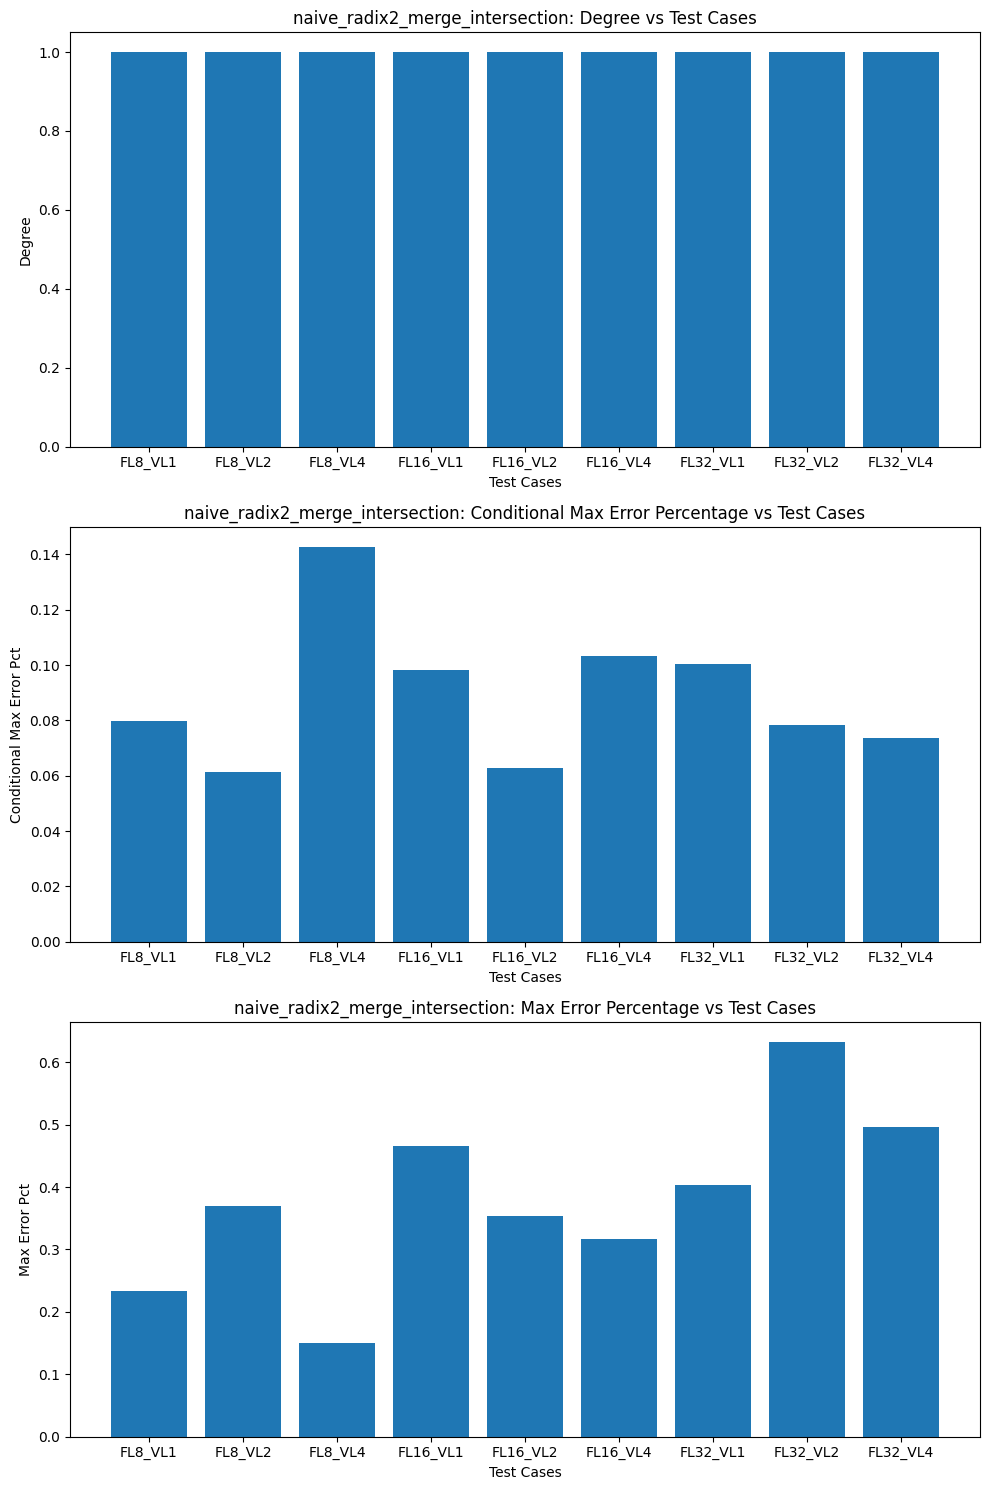

In [ ]:
for isect_unit_name in all_res_summary:
    print("isect unit:",isect_unit_name)
    res_summary=all_res_summary[isect_unit_name]
    plot_result(res_summary, meta_test_cases, isect_unit_name=isect_unit_name)

In [ ]:
def model_to_sympy(model, feature_names):
    # Ensure that the model is an instance of NormalizedTransformedPolynomial
    if not isinstance(model, mo_.NormalizedTransformedPolynomial):
        raise ValueError("Model must be an instance of NormalizedTransformedPolynomial")

    # Extracting components from the model's pipeline
    scaler = model.pipeline.named_steps['scaler']
    poly = model.pipeline.named_steps['preprocessor']
    estimator = model.pipeline.named_steps['estimator']

    # Extracting StandardScaler parameters
    means = scaler.mean_
    scales = scaler.scale_

    # Creating SymPy symbols for input features
    symbols = [sp.symbols(name) for name in feature_names]

    # Apply log or sqrt transformation to the symbols if enabled
    if model.lg:
        print("Taking log")
        transformed_symbols = [sp.log(symbol) for symbol in symbols]
    elif model.sqrt:
        print("Taking sqrt")
        transformed_symbols = [sp.sqrt(symbol) for symbol in symbols]
    else:
        transformed_symbols = symbols



    # Applying StandardScaler transformation to transformed symbols
    scaled_symbols = [(symbol - mean) / scale for symbol, mean, scale in zip(transformed_symbols, means, scales)]

    # Extracting PolynomialFeatures
    degrees = poly.powers_
    coefficients = estimator.coef_.flatten()

    # Constructing the polynomial expression
    expression = sp.Float(estimator.intercept_)
    for coef, degree in zip(coefficients, degrees):
        term = coef * sp.prod([s**d for s, d in zip(scaled_symbols, degree)])
        expression += term
        print("coeff:",coef)
        print("degree:",degree)
        print("term:",term)
        print("expression:",expression)


    # Final transformation for sqrt or log
    if model.lg:
        print("Doing exp")
        expression = sp.exp(expression)
    elif model.sqrt:
        print("Doing square")
        expression = expression**2

    print("Symbols:", symbols)
    print("Transformed symbols:", transformed_symbols)
    print("Scaled symbols:",scaled_symbols)
    print("Expression:", expression)

    return expression, symbols

In [ ]:
def generate_differentiable_piecewise_term(output_throughput_symbol_name, condition_symbol_name_list, condition_symbol_value_list, safe_value):
    # Define the symbols
    output_throughput_symbol = symbols(output_throughput_symbol_name)
    condition_symbols = symbols(condition_symbol_name_list)

    # Calculate K using a Python loop
    K = sum((condition_symbols[i] - condition_symbol_value_list[i])**2 for i in range(len(condition_symbol_name_list)))

    # Construct the full expression
    safe_value_expression = safe_value * K / (0.0101 + K)
    full_expression = output_throughput_symbol + safe_value_expression

    return full_expression, safe_value_expression

In [ ]:
def get_sympy_expressions_in_fiberLength_vectorLength(all_results, meta_test_cases, pipeline_depth="pipeline_depth", safe_value=1000):
    meta_features = list(meta_test_cases[0].keys())
    model_sp_dict={}
    print("Generating sympy model expressions for all intersection units & meta-test-cases")
    for isect_unit_name in all_results:
        model_sp_dict[isect_unit_name]=[]
        print("- Generating sympy model expressions for intersection unit",isect_unit_name)
        results = all_results[isect_unit_name]
        for idx in range(len(meta_test_cases)):
            print("-- Generating sympy model expression for mtc",str(idx),", intersection unit",isect_unit_name)
            print("--- Meta test-case:",meta_test_cases[idx])
            meta_test_case = meta_test_cases[idx]
            model=results[idx]['best_result']['test_res']['model']
            model_sp=model_to_sympy(model, d_.input_features)
            differentiable_piecewise_term, safe_value_term = generate_differentiable_piecewise_term(pipeline_depth, \
                                                                                                    meta_features, \
                                                                                                    [meta_test_case[ft] \
                                                                                                        for ft in meta_features], \
                                                                                                    safe_value)
            model_sp_dict[isect_unit_name].append({"model_sp":model_sp, \
                                                   "differentiable_piecewise_term":differentiable_piecewise_term, \
                                                   "safe_value_term":safe_value_term, \
                                                   "meta_test_case":meta_test_case})
            print("-- ",str(model_sp))
            print("-- Done, idx =",str(idx),", intersection unit",isect_unit_name)
        print("- => Done, generating expressions for",isect_unit_name)
    print("=> Done, generating all sympy model expressions")
    return model_sp_dict

In [ ]:
def substitute_expression(expression, substitution_dict):
    # Ensure that the substitution expressions are in SymPy format
    substitution_dict = {sp.Symbol(key): sp.sympify(value) for key, value in substitution_dict.items()}

    # Substitute the new expressions in the expression
    substituted_expression = expression.subs(substitution_dict)

    return substituted_expression

In [ ]:
def substitute_in_model_sp_dict(model_sp_dict, substitution_dict):
    # Deep copy the original dictionary to avoid modifying it directly
    modified_dict = copy.deepcopy(model_sp_dict)

    # Iterate through each intersection unit and their list of results
    for unit_name, results in modified_dict.items():
        for result in results:
            # Substitute in 'model_sp', 'differentiable_piecewise_term', and 'safe_value_term'
            for key in ['model_sp', 'differentiable_piecewise_term', 'safe_value_term']:
                expression = result[key][0] if key == 'model_sp' else result[key]
                substituted_expression = substitute_expression(expression, substitution_dict)
                result[key] = substituted_expression if key != 'model_sp' else (substituted_expression, result[key][1])

    return modified_dict

In [ ]:
def create_min_expressions(model_sp_dict):
    min_expressions = {}

    for unit_name, test_results in model_sp_dict.items():
        min_args = [result['model_sp'][0] + result['safe_value_term'] for result in test_results]
        min_expression = Min(*min_args)
        min_expressions[unit_name] = min_expression

    return min_expressions

In [ ]:
sp.init_printing()

new_input_features=['md_in0_nc','md_in0_vectorization','md_in0_pr','md_in0_cr','md_in1_pr','md_in1_cr']
substitution_dict={'fiberLength':'md_in0_nc','vectorLength':'md_in0_vectorization','compressedFiberLength0':'md_in0_nc*md_in0_pr/md_in0_cr','compressedFiberLength1':'md_in0_nc*md_in1_pr/md_in1_cr'}

model_sp_dict = get_sympy_expressions_in_fiberLength_vectorLength(all_results,meta_test_cases)

Generating sympy model expressions for all intersection units & meta-test-cases
- Generating sympy model expressions for intersection unit direct_mapped_intersection_unit
-- Generating sympy model expression for mtc 0 , intersection unit direct_mapped_intersection_unit
--- Meta test-case: {'fiberLength': 8, 'vectorLength': 1}
Taking log
coeff: 0.0
degree: [0 0 0 0]
term: 0
expression: -1.06484376703151
coeff: 0.3192324191502954
degree: [1 0 0 0]
term: 0.530324952168092*log(compressedFiberLength0) - 0.678265403791297
expression: 0.530324952168092*log(compressedFiberLength0) - 1.74310917082281
coeff: 0.36390140580611585
degree: [0 1 0 0]
term: 0.527439636160893*log(compressedFiberLength1) - 0.664576975857088
expression: 0.530324952168092*log(compressedFiberLength0) + 0.527439636160893*log(compressedFiberLength1) - 2.4076861466799
coeff: 0.0
degree: [0 0 1 0]
term: 0
expression: 0.530324952168092*log(compressedFiberLength0) + 0.527439636160893*log(compressedFiberLength1) - 2.4076861466799

In [ ]:
subs_model_sp_dict = substitute_in_model_sp_dict(model_sp_dict, substitution_dict)
print(subs_model_sp_dict)

{'direct_mapped_intersection_unit': [{'model_sp': (0.0900233546071628*(md_in0_nc*md_in0_pr/md_in0_cr)**0.530324952168092*(md_in0_nc*md_in1_pr/md_in1_cr)**0.527439636160893, [compressedFiberLength0, compressedFiberLength1, fiberLength, vectorLength]), 'differentiable_piecewise_term': pipeline_depth + (1000*(md_in0_nc - 8)**2 + 1000*(md_in0_vectorization - 1)**2)/((md_in0_nc - 8)**2 + (md_in0_vectorization - 1)**2 + 0.0101), 'safe_value_term': (1000*(md_in0_nc - 8)**2 + 1000*(md_in0_vectorization - 1)**2)/((md_in0_nc - 8)**2 + (md_in0_vectorization - 1)**2 + 0.0101), 'meta_test_case': {'fiberLength': 8, 'vectorLength': 1}}, {'model_sp': (0.177344321145269*(md_in0_nc*md_in0_pr/md_in0_cr)**0.450453124317432*(md_in0_nc*md_in1_pr/md_in1_cr)**0.508563792646416, [compressedFiberLength0, compressedFiberLength1, fiberLength, vectorLength]), 'differentiable_piecewise_term': pipeline_depth + (1000*(md_in0_nc - 8)**2 + 1000*(md_in0_vectorization - 2)**2)/((md_in0_nc - 8)**2 + (md_in0_vectorization 

In [ ]:
min_expression_dict = create_min_expressions(subs_model_sp_dict)
min_expression_dict

{'direct_mapped_intersection_unit': Min(0.177344321145269*(md_in0_nc*md_in0_pr/md_in0_cr)**0.450453124317432*(md_in0_nc*md_in1_pr/md_in1_cr)**0.508563792646416 + (1000*(md_in0_nc - 8)**2 + 1000*(md_in0_vectorization - 2)**2)/((md_in0_nc - 8)**2 + (md_in0_vectorization - 2)**2 + 0.0101), 0.0661818371875179*(md_in0_nc*md_in0_pr/md_in0_cr)**0.499713334304178*(md_in0_nc*md_in1_pr/md_in1_cr)**0.564390764625518 + (1000*(md_in0_nc - 16)**2 + 1000*(md_in0_vectorization - 2)**2)/((md_in0_nc - 16)**2 + (md_in0_vectorization - 2)**2 + 0.0101), 0.053581944510237*(md_in0_nc*md_in0_pr/md_in0_cr)**0.523172223538281*(md_in0_nc*md_in1_pr/md_in1_cr)**0.556192066466687 + (1000*(md_in0_nc - 32)**2 + 1000*(md_in0_vectorization - 4)**2)/((md_in0_nc - 32)**2 + (md_in0_vectorization - 4)**2 + 0.0101), 0.0900233546071628*(md_in0_nc*md_in0_pr/md_in0_cr)**0.530324952168092*(md_in0_nc*md_in1_pr/md_in1_cr)**0.527439636160893 + (1000*(md_in0_nc - 8)**2 + 1000*(md_in0_vectorization - 1)**2)/((md_in0_nc - 8)**2 + (md

In [ ]:
# Transform old input features ['compressedFiberLength0','compressedFiberLength1','fiberLength','vectorLength']
# to ['md_in0_nc','md_in0_vectorization','md_in0_pr','md_in0_cr','md_in1_pr','md_in1_cr']
#
# [b0,b1,b2,b3] => [b2,b3,b0,b2,b1,b2]

def transform_input_features(X):
    # Select and reorder columns as per the formula
    transformed_columns = [X[:,2], X[:,3], X[:,0], X[:,2], X[:,1], X[:,2]]

    # Concatenate the columns to form a new matrix
    return np.column_stack(transformed_columns)


In [ ]:
d_.input_features

['compressedFiberLength0',
 'compressedFiberLength1',
 'fiberLength',
 'vectorLength']

In [ ]:
import inspect

class MinModel(BaseEstimator, RegressorMixin):
    def __init__(self, sympy_expression, input_features, feature_xform = transform_input_features):
        self.input_features = input_features
        symbols = [sp.Symbol(feature) for feature in input_features]
        self.func = sp.lambdify(symbols, sympy_expression, 'numpy')
        self.feature_xform = feature_xform

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        X_xform = self.feature_xform(X)
        X = np.asarray(X_xform)

        # Split the columns of X and pass them as separate arguments to the function
        arguments = [X[:, i] for i in range(X.shape[1])]

        predictions = self.func(*arguments)

        # Reshape to ensure output is a matrix with one column
        predictions = predictions.reshape(-1, 1)
        return predictions


In [ ]:
new_input_features

['md_in0_nc',
 'md_in0_vectorization',
 'md_in0_pr',
 'md_in0_cr',
 'md_in1_pr',
 'md_in1_cr']

In [ ]:
def plot_comparison(test_cases_list, true_targets_list, predicted_results_list, isect_list,
                    title="Average Cycles per Intersection", show_grid=True, subplot_width=2):
    all_combinations = np.vstack([test_cases[:, [2, 3]] for test_cases in test_cases_list])
    unique_combinations = np.unique(all_combinations, axis=0)
    num_plots = len(unique_combinations)

    rows = (num_plots + subplot_width - 1) // subplot_width
    fig, axs = plt.subplots(rows, subplot_width, figsize=(subplot_width*6, rows*4), squeeze=False)

    for index, (fiber_length, vector_length) in enumerate(unique_combinations):
        ax = axs[index // subplot_width, index % subplot_width]

        for test_cases, true_values, predicted, isect_name in zip(test_cases_list, true_targets_list, predicted_results_list, isect_list):
            sparsity0 = (1.0 - test_cases[:, 0] / test_cases[:, 2])
            sparsity1 = (1.0 - test_cases[:, 1] / test_cases[:, 2])
            geometric_mean_sparsity = np.sqrt(sparsity0 * sparsity1)

            combination_mask = [f == fiber_length and v == vector_length for f, v in zip(test_cases[:, 2].astype(int), test_cases[:, 3].astype(int))]
            filtered_sparsity = geometric_mean_sparsity[combination_mask].flatten()
            filtered_true_values = true_values[combination_mask].flatten()
            filtered_predicted = predicted[combination_mask].flatten()

            sort_indices = np.argsort(filtered_sparsity)
            filtered_sparsity = filtered_sparsity[sort_indices]
            filtered_true_values = filtered_true_values[sort_indices]
            filtered_predicted = filtered_predicted[sort_indices]

            # Plot true values
            true_scatter = ax.scatter(filtered_sparsity, filtered_true_values, marker='.', label=f'True - {isect_name}' if index == 0 else "", zorder=1)

            # Get current color of the scatter to darken for the line
            current_color = true_scatter.get_facecolor().flatten()
            # Darken the color for the plot line
            darker_color = current_color * 0.8  # Reduce brightness by 20%
            darker_color[-1] = 1  # Set alpha to 1 if it's not

            # Plot predicted values with a dashed line, slightly darker color, and on top of the scatter plot
            ax.plot(filtered_sparsity, filtered_predicted, '--', color=darker_color, label=f'Predicted - {isect_name}' if index == 0 else "", zorder=2)

        ax.set_xlabel('Geometric Mean of Operand Sparsities')
        ax.set_ylabel('Average Intersection Matches per cycle')
        modified_title = f"{title}\n(FiberLength={fiber_length}, VectorLength={vector_length})"
        ax.set_title(modified_title)

        y_upper_limit = max(1.5, max(np.max(true_targets_list), np.max(predicted_results_list)))
        ax.set_ylim(bottom=0, top=y_upper_limit)
        ax.set_xlim(0, 1.0)
        if show_grid:
            ax.grid(True)

        if index == 0:  # Only display the legend on the top-left plot
            ax.legend(loc='best')

    # Hide any unused subplots
    if rows * subplot_width > num_plots:
        for idx in range(num_plots, rows * subplot_width):
            axs.flat[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
d_.input_features

['compressedFiberLength0',
 'compressedFiberLength1',
 'fiberLength',
 'vectorLength']

In [ ]:
test_batch_size=1000

results_list=[]
isect_list=[]
test_cases_list=[]
true_targets_list=[]
predicted_results_list=[]
for isect_name in min_expression_dict:
    print("Testing",isect_name)
    min_expression = min_expression_dict[isect_name]
    print("- Min expression:",min_expression)
    min_model=MinModel(min_expression, new_input_features)

    dataloader = d_.test_case_dataloader_from_params(sparsity0_range,
                                                      sparsity1_range,
                                                      fiberLength_list,
                                                      vectorLength_list,
                                                      test_batch_size,
                                                      num_tests,
                                                      isect_unit_dict[isect_name])

    _, mse_r2, predicted_results, test_cases, true_targets = te_.test_model_expression(min_model, \
                                                                                      dataloader, \
                                                                                      column_expression, \
                                                                                      target_features)

    test_cases_list.append(test_cases)
    true_targets_list.append(true_targets)
    predicted_results_list.append(predicted_results)

    #p2d_.plot_comparison(test_cases, true_targets, predicted_results, sparsity1_bin_count=100, title="Values vs Operand0 sparsity for different Operand1 sparsity ranges", sparsity0_range=[0, float('inf')], sparsity1_range=[0, float('inf')])
    #plot_comparison(test_cases, true_targets, predicted_results, title="Expected Cycles vs Geometric Mean of Sparsities")

    max_error_pct = calculate_conditional_max_error_pct(test_cases, true_targets, predicted_results, [0.0,1.0], [0.0,1.0])
    results_list.append({'max_error_pct':max_error_pct})
    print("- max error pct:",max_error_pct)
    try:
        conditional_max_error_pct = calculate_conditional_max_error_pct(test_cases, true_targets, predicted_results, cfg["eval_sparsity0_range"], cfg["eval_sparsity1_range"])
        results_list[-1]['conditional_max_error_pct']=conditional_max_error_pct
        print("- conditional max error pct:",conditional_max_error_pct)
    except:
        print("- conditional max error pct: N/A")


    isect_list.append(isect_name)

Testing direct_mapped_intersection_unit
- Min expression: Min(0.177344321145269*(md_in0_nc*md_in0_pr/md_in0_cr)**0.450453124317432*(md_in0_nc*md_in1_pr/md_in1_cr)**0.508563792646416 + (1000*(md_in0_nc - 8)**2 + 1000*(md_in0_vectorization - 2)**2)/((md_in0_nc - 8)**2 + (md_in0_vectorization - 2)**2 + 0.0101), 0.0661818371875179*(md_in0_nc*md_in0_pr/md_in0_cr)**0.499713334304178*(md_in0_nc*md_in1_pr/md_in1_cr)**0.564390764625518 + (1000*(md_in0_nc - 16)**2 + 1000*(md_in0_vectorization - 2)**2)/((md_in0_nc - 16)**2 + (md_in0_vectorization - 2)**2 + 0.0101), 0.053581944510237*(md_in0_nc*md_in0_pr/md_in0_cr)**0.523172223538281*(md_in0_nc*md_in1_pr/md_in1_cr)**0.556192066466687 + (1000*(md_in0_nc - 32)**2 + 1000*(md_in0_vectorization - 4)**2)/((md_in0_nc - 32)**2 + (md_in0_vectorization - 4)**2 + 0.0101), 0.0900233546071628*(md_in0_nc*md_in0_pr/md_in0_cr)**0.530324952168092*(md_in0_nc*md_in1_pr/md_in1_cr)**0.527439636160893 + (1000*(md_in0_nc - 8)**2 + 1000*(md_in0_vectorization - 1)**2)/((m

Running test cases: 100%|██████████| 1000/1000 [01:03<00:00, 15.69it/s]


Mean Squared Error (MSE): 0.010323033460734894
R^2 Score: 0.9465340628703968
- max error pct: 0.9298544865048273
- conditional max error pct: 0.41370343416926736
Testing skipahead_radix2_merge_intersection
- Min expression: Min(0.0816394436796591*(md_in0_nc*md_in0_pr/md_in0_cr)**0.409944201335221*(md_in0_nc*md_in1_pr/md_in1_cr)**0.408994878263821 + (1000*(md_in0_nc - 16)**2 + 1000*(md_in0_vectorization - 4)**2)/((md_in0_nc - 16)**2 + (md_in0_vectorization - 4)**2 + 0.0101), 0.154528465717489*(md_in0_nc*md_in0_pr/md_in0_cr)**0.45861271167502*(md_in0_nc*md_in1_pr/md_in1_cr)**0.390359413886421 + (1000*(md_in0_nc - 8)**2 + 1000*(md_in0_vectorization - 4)**2)/((md_in0_nc - 8)**2 + (md_in0_vectorization - 4)**2 + 0.0101), 0.135135595239382*(md_in0_nc*md_in0_pr/md_in0_cr)**0.465441053200476*(md_in0_nc*md_in1_pr/md_in1_cr)**0.409074769370023 + (1000*(md_in0_nc - 8)**2 + 1000*(md_in0_vectorization - 2)**2)/((md_in0_nc - 8)**2 + (md_in0_vectorization - 2)**2 + 0.0101), 0.0330450227586578*(md_in0

Running test cases: 100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


Mean Squared Error (MSE): 0.0014229891015975981
R^2 Score: 0.9605382452955498
- max error pct: 0.7898144732759754
- conditional max error pct: 0.11193571036487492
Testing naive_radix2_merge_intersection
- Min expression: Min(0.105875336244488*(md_in0_nc*md_in0_pr/md_in0_cr)**0.415201746509399*(md_in0_nc*md_in1_pr/md_in1_cr)**0.414832840088104 + (1000*(md_in0_nc - 8)**2 + 1000*(md_in0_vectorization - 4)**2)/((md_in0_nc - 8)**2 + (md_in0_vectorization - 4)**2 + 0.0101), 0.0482564819365224*(md_in0_nc*md_in0_pr/md_in0_cr)**0.431870620343634*(md_in0_nc*md_in1_pr/md_in1_cr)**0.376209933588504 + (1000*(md_in0_nc - 16)**2 + 1000*(md_in0_vectorization - 4)**2)/((md_in0_nc - 16)**2 + (md_in0_vectorization - 4)**2 + 0.0101), 0.0958452162753995*(md_in0_nc*md_in0_pr/md_in0_cr)**0.457031585704196*(md_in0_nc*md_in1_pr/md_in1_cr)**0.415718745294848 + (1000*(md_in0_nc - 8)**2 + 1000*(md_in0_vectorization - 2)**2)/((md_in0_nc - 8)**2 + (md_in0_vectorization - 2)**2 + 0.0101), 0.100372995248411*(md_in0_n

Running test cases: 100%|██████████| 1000/1000 [01:04<00:00, 15.60it/s]


Mean Squared Error (MSE): 0.0010427957722427112
R^2 Score: 0.9529139630294629
- max error pct: 0.6330947665870523
- conditional max error pct: 0.15377066211609716


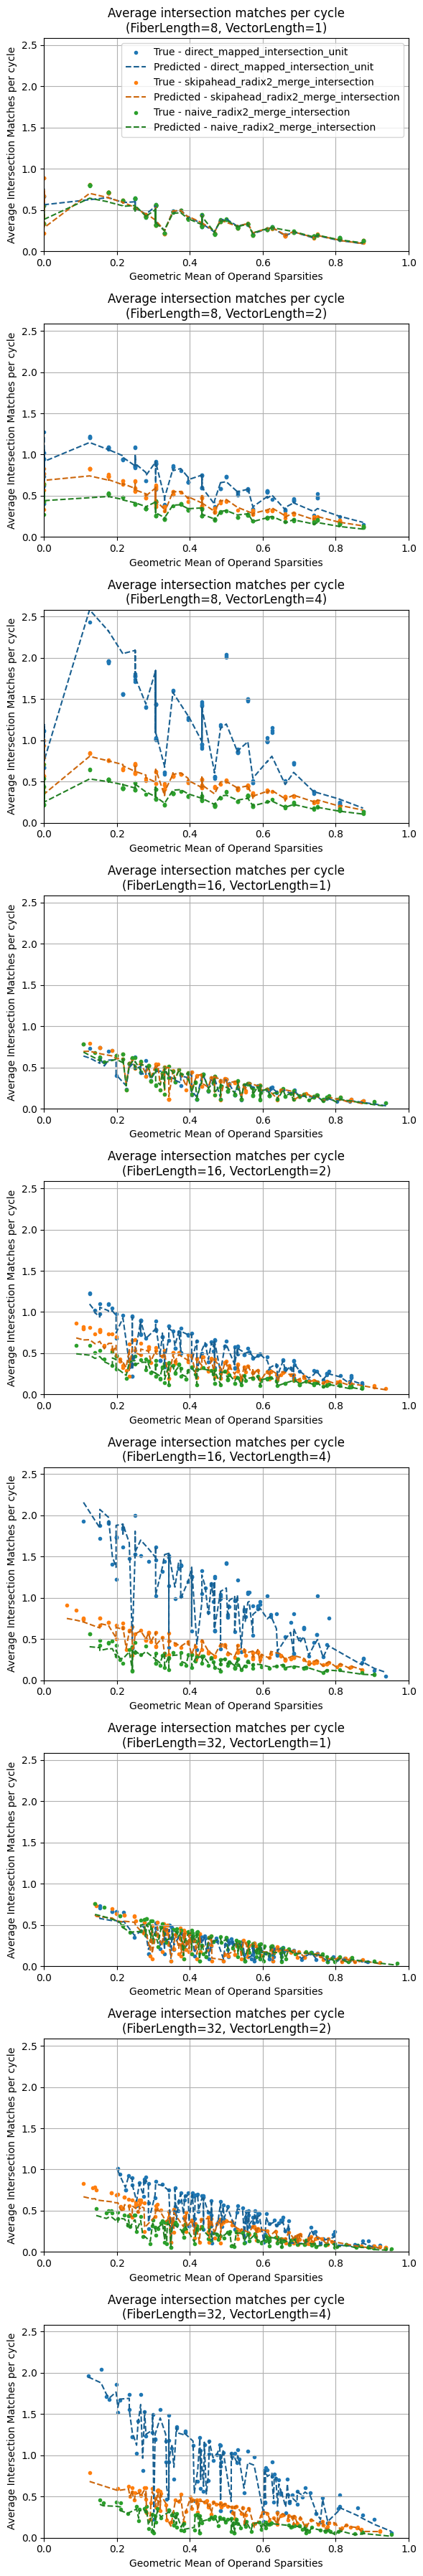

In [ ]:
plot_comparison(test_cases_list, true_targets_list, predicted_results_list, isect_list, title="Average intersection matches per cycle",subplot_width=1)

In [ ]:
def plot_results(results_list, isect_list):
    # Extracting results
    max_error_pct_list = [res.get('max_error_pct', None) for res in results_list]
    conditional_max_error_pct_list = [res.get('conditional_max_error_pct', None) for res in results_list]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Max Error Percentage Bar Chart
    axs[0].bar(isect_list, max_error_pct_list)
    axs[0].set_title('Max Error Percentage vs Intersection Units')
    axs[0].set_xlabel('Intersection Units')
    axs[0].set_ylabel('Max Error Pct')

    # Conditional Max Error Percentage Bar Chart
    axs[1].bar(isect_list, conditional_max_error_pct_list)
    axs[1].set_title('Conditional Max Error Percentage vs Intersection Units')
    axs[1].set_xlabel('Intersection Units')
    axs[1].set_ylabel('Conditional Max Error Pct')

    plt.tight_layout()
    plt.show()

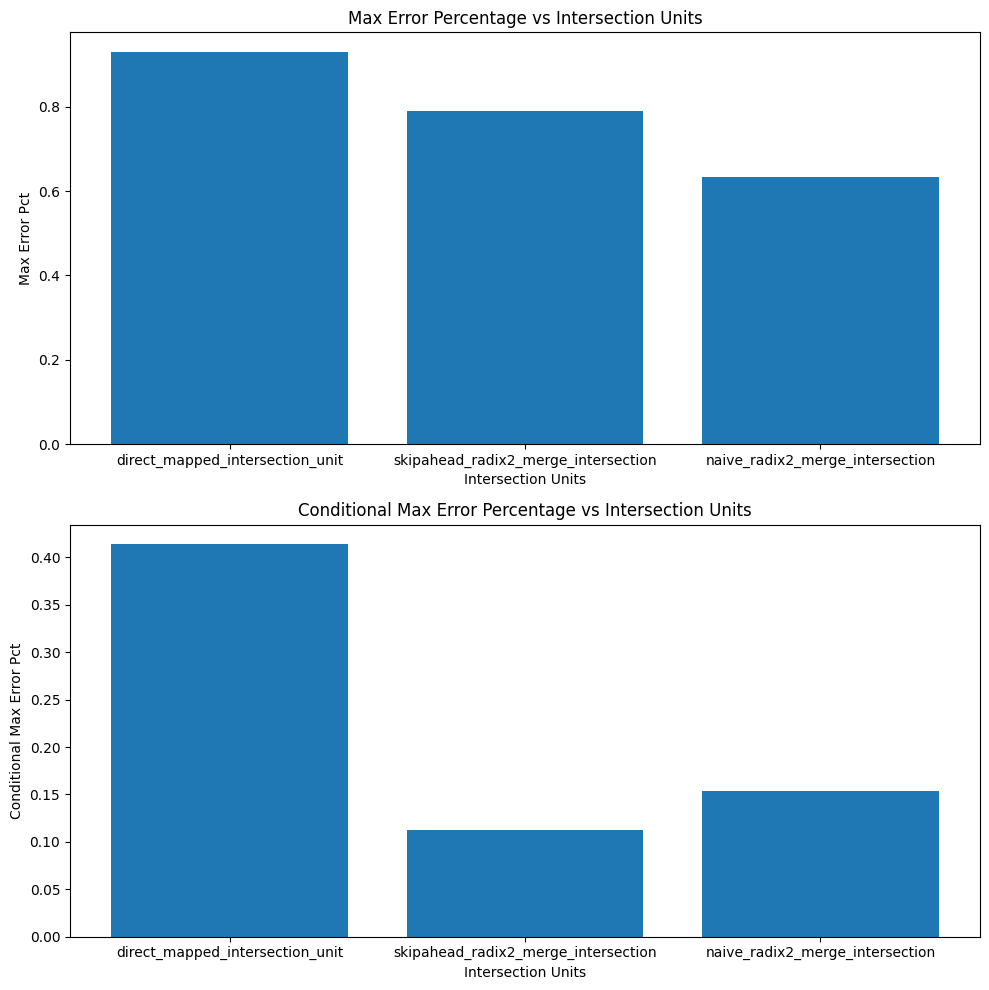

In [ ]:
plot_results(results_list, isect_list)

In [ ]:
def generate_modelscript_constraints(subs_model_sp_dict, pipeline_depth_symbol_name, output_throughput_symbol_name, new_feature_names):
    # Dictionary to store the constraints for each intersection unit
    constraints_dict = {}

    pipeline_depth_symbol = sp.Symbol(pipeline_depth_symbol_name)
    output_throughput_symbol = sp.Symbol(output_throughput_symbol_name)

    for unit_name, results in subs_model_sp_dict.items():
        print(unit_name)
        # List to store the constraints for the current intersection unit
        constraints = []

        for result in tqdm(results, desc=f"Processing {unit_name}", unit="constraint"):
            # Extract and sympify the expressions
            model_sp_expr = sp.sympify(result['model_sp'][0])
            safe_value_term_expr = sp.sympify(result['safe_value_term'])

            # Create the inequality constraint
            constraint = (output_throughput_symbol <= model_sp_expr*pipeline_depth_symbol + safe_value_term_expr)

            # Convert constraint to string
            constraint_str = str(constraint)

            # Replace symbols with '@' prefixed versions including pipeline_depth_symbol
            print(pipeline_depth_symbol_name)
            all_symbols = new_feature_names + [pipeline_depth_symbol_name,output_throughput_symbol_name]
            for symbol in all_symbols:
                pattern = r'\b' + re.escape(symbol) + r'\b'  # Match whole word only
                constraint_str = re.sub(pattern, "( @" + symbol + " )", constraint_str)

            constraints.append(constraint_str)

        # Store the constraints for the current intersection unit
        constraints_dict[unit_name] = constraints

    return constraints_dict

In [ ]:
constr_dict=generate_modelscript_constraints(subs_model_sp_dict, "md_out_vectorization", "md_out_pr", new_input_features)
for isect_name in constr_dict:
    print(isect_name)
    for constr in constr_dict[isect_name]:
        print(constr)

direct_mapped_intersection_unit


Processing direct_mapped_intersection_unit: 100%|██████████| 9/9 [00:00<00:00, 111.74constraint/s]


md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
skipahead_radix2_merge_intersection


Processing skipahead_radix2_merge_intersection: 100%|██████████| 9/9 [00:00<00:00, 146.31constraint/s]


md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
naive_radix2_merge_intersection


Processing naive_radix2_merge_intersection:   0%|          | 0/9 [00:00<?, ?constraint/s]

md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization
md_out_vectorization


Processing naive_radix2_merge_intersection: 100%|██████████| 9/9 [00:00<00:00, 144.02constraint/s]

md_out_vectorization
direct_mapped_intersection_unit
( @md_out_pr ) <= 0.0900233546071628*( @md_out_vectorization )*(( @md_in0_nc )*( @md_in0_pr )/( @md_in0_cr ))**0.530324952168092*(( @md_in0_nc )*( @md_in1_pr )/( @md_in1_cr ))**0.527439636160893 + (1000*(( @md_in0_nc ) - 8)**2 + 1000*(( @md_in0_vectorization ) - 1)**2)/((( @md_in0_nc ) - 8)**2 + (( @md_in0_vectorization ) - 1)**2 + 0.0101)
( @md_out_pr ) <= 0.177344321145269*( @md_out_vectorization )*(( @md_in0_nc )*( @md_in0_pr )/( @md_in0_cr ))**0.450453124317432*(( @md_in0_nc )*( @md_in1_pr )/( @md_in1_cr ))**0.508563792646416 + (1000*(( @md_in0_nc ) - 8)**2 + 1000*(( @md_in0_vectorization ) - 2)**2)/((( @md_in0_nc ) - 8)**2 + (( @md_in0_vectorization ) - 2)**2 + 0.0101)
( @md_out_pr ) <= 0.178633126637616*( @md_out_vectorization )*(( @md_in0_nc )*( @md_in0_pr )/( @md_in0_cr ))**0.68350789192791*(( @md_in0_nc )*( @md_in1_pr )/( @md_in1_cr ))**0.689505154740929 + (1000*(( @md_in0_nc ) - 8)**2 + 1000*(( @md_in0_vectorization ) - 4)*

In [ ]:
for isect_name in constr_dict:
    print(isect_name)
    for constr in constr_dict[isect_name]:
        print(constr.replace("@","TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD."))

direct_mapped_intersection_unit
( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_out_pr ) <= 0.0900233546071628*( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_out_vectorization )*(( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_nc )*( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_pr )/( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_cr ))**0.530324952168092*(( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_nc )*( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in1_pr )/( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in1_cr ))**0.527439636160893 + (1000*(( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_nc ) - 8)**2 + 1000*(( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_vectorization ) - 1)**2

In [ ]:
data_to_pickle = {
    "new_input_features": new_input_features,
    "substitution_dict": substitution_dict,
    "model_sp_dict": model_sp_dict,
    "subs_model_sp_dict": subs_model_sp_dict,
    "min_expression_dict": min_expression_dict,
    "constr_dict": constr_dict,
    "isect_unit_dict": isect_unit_dict,
    "column_expression": column_expression,
    "target_features": target_features,
    "sparsity0_range": sparsity0_range,
    "sparsity1_range": sparsity1_range,
    "num_tests": num_tests,
    "fiberLength_list": fiberLength_list,
    "vectorLength_list": vectorLength_list
}

# Call the function to pickle and download the data
pickle_list_with_timestamp_and_download(data_to_pickle, "subs_model_backup")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'subs_model_backup_20240123-100952.pkl'

In [ ]:
  isect_unit = isect_unit_list[1]
  print(isect_unit)
  dataloader = d_.test_case_dataloader_from_params(sparsity0_range,
                                                    sparsity1_range,
                                                    fiberLength_list,
                                                    vectorLength_list,
                                                    100,
                                                    num_tests,
                                                    isect_unit
  )

<function skipahead_radix2_merge_intersection at 0x7b5f6b2b6710>
